# 0. The problem

Source: https://www.kaggle.com/competitions/rossmann-store-sales/overview

## Context

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

## Solution

Predict 6 weeks of daily sales for 1115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams! 

# 1. Data description

**Files**
- train.csv - historical data including Sales
- test.csv - historical data excluding Sales
- store.csv - supplemental information about the stores

**Data fields**
- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## 1.1. Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.model_selection import train_test_split

## 1.2. Loading data

In [2]:
df_store = pd.read_csv(filepath_or_buffer="../data/store.csv")
df_train_raw = pd.read_csv(filepath_or_buffer="../data/train.csv", low_memory=False)
df_val = pd.read_csv(filepath_or_buffer="../data/test.csv")

# 2. Exploratory data analisys

## 2.1. Data description

### 2.1.1. Store

In [3]:
# Information of each store
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [4]:
# Is there any duplicated store?
assert df_store.duplicated(subset=['Store']).sum() == 0

In [5]:
df_store.sample(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
610,611,a,a,8080.0,12.0,2002.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
71,72,a,a,2200.0,12.0,2009.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
976,977,a,a,520.0,9.0,2005.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
1006,1007,c,c,4180.0,9.0,2012.0,0,NaN,NaN,NaN
376,377,a,c,100.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov"
146,147,d,c,8540.0,NaN,NaN,0,NaN,NaN,NaN
926,927,a,a,480.0,NaN,NaN,0,NaN,NaN,NaN
862,863,a,c,21370.0,11.0,2010.0,0,NaN,NaN,NaN
875,876,a,a,21790.0,4.0,2005.0,1,18.0,2015.0,"Feb,May,Aug,Nov"
962,963,a,c,23620.0,11.0,2013.0,0,NaN,NaN,NaN


In [6]:
df_store["PromoInterval"].value_counts()

PromoInterval
Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: count, dtype: int64

In [7]:
# When a store is not participating of a continuing promotion, "Promo2SinceWeek", "Promo2SinceYear" and "PromoInterval" have NaN
df_store[["Promo2", "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval"]]

,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,0,NaN,NaN,NaN
1,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN
...,...,...,...,...
1110,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,0,NaN,NaN,NaN
1112,0,NaN,NaN,NaN
1113,0,NaN,NaN,NaN


In [8]:
df_store.groupby("Promo2")["Promo2SinceWeek"].unique()

Promo2
0                                                [nan]
1    [13.0, 14.0, 1.0, 45.0, 40.0, 26.0, 22.0, 5.0,...
Name: Promo2SinceWeek, dtype: object

In [9]:
df_store.groupby("Promo2")["Promo2SinceYear"].unique()

Promo2
0                                                [nan]
1    [2010.0, 2011.0, 2012.0, 2009.0, 2014.0, 2015....
Name: Promo2SinceYear, dtype: object

In [10]:
df_store.groupby("Promo2")["PromoInterval"].unique()

Promo2
0                                                [nan]
1    [Jan,Apr,Jul,Oct, Feb,May,Aug,Nov, Mar,Jun,Sep...
Name: PromoInterval, dtype: object

**OBS.:**
- StoreType: change to category
- Assortment: change to category
- CompetitionOpenSinceMonth: change to int and add instance month when is NaN
- CompetitionOpenSinceYear: change to int and add instance year when is NaN
- Promo2SinceWeek: fill NaN with zero; change to int
- Promo2SinceYear: fill NaN with zero; change to int
- PromoInterval: fill NaN with zero; there are three intervals, change to a categorical value

StoreType

In [11]:
df_store["StoreType"].value_counts()

StoreType
a    602
d    348
c    148
b     17
Name: count, dtype: int64

Assortment

In [12]:
assortment_map = {"a": "basic",
                  "b": "extra",
                  "c": "extended"}

In [13]:
df_store["Assortment"] = df_store["Assortment"].map(assortment_map)

In [14]:
df_store["Assortment"].value_counts()

Assortment
basic       593
extended    513
extra         9
Name: count, dtype: int64

In [15]:
df_store["Assortment"].isna().sum()

np.int64(0)

CompetitionDistance
- NaN values could be related to a store with no competitors nearby
- Replace NaN with the max distance

In [16]:
df_store[df_store["CompetitionDistance"].isna()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,basic,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,extended,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,basic,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [17]:
df_store["CompetitionDistance"].describe()

count     1112.000000
mean      5404.901079
std       7663.174720
min         20.000000
25%        717.500000
50%       2325.000000
75%       6882.500000
max      75860.000000
Name: CompetitionDistance, dtype: float64

<Axes: xlabel='CompetitionDistance'>

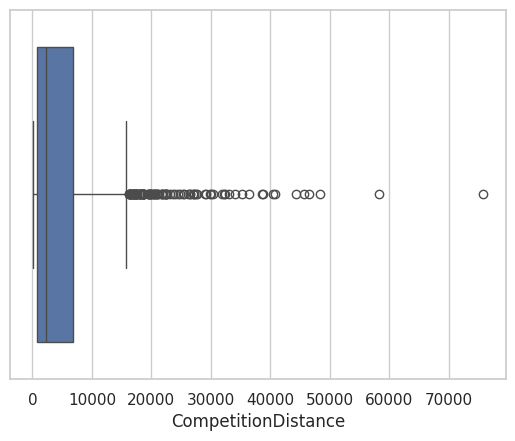

In [18]:
sns.boxplot(data=df_store, x=df_store["CompetitionDistance"])

In [19]:
df_store["CompetitionDistance"] = df_store["CompetitionDistance"].fillna(value=df_store["CompetitionDistance"].max())

In [20]:
df_store["CompetitionDistance"].isna().sum()

np.int64(0)

### 2.1.2. Train

In [21]:
df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


Date

In [22]:
# Convert Date type to datetime
df_train_raw["Date"] = pd.to_datetime(df_train_raw["Date"])

In [23]:
df_train_raw

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


StateHoliday

In [24]:
holidays = {"a": "public",
            "b": "easter",
            "c": "xmas",
            "0": "none"}

df_train_raw.loc[:, "StateHoliday"] = df_train_raw["StateHoliday"].map(holidays)

In [25]:
df_train_raw["StateHoliday"].value_counts()

StateHoliday
none      986159
public     20260
easter      6690
xmas        4100
Name: count, dtype: int64

In [26]:
df_train_raw.groupby("StateHoliday")["Open"].value_counts(normalize=True)

StateHoliday  Open
easter        0       0.978326
              1       0.021674
none          1       0.855320
              0       0.144680
public        0       0.965745
              1       0.034255
xmas          0       0.982683
              1       0.017317
Name: proportion, dtype: float64

In [27]:
# There should be no repeated dates for each store
assert df_train_raw.duplicated(subset=["Store", "Date"]).sum() == 0

In [28]:
# Number of instances for each store
df_train_raw.groupby("Store").size().value_counts()

942    934
758    180
941      1
Name: count, dtype: int64

In [29]:
# Closed store has no sales, so it is not relevant
original_shape = df_train_raw.shape
df_train_raw = df_train_raw[df_train_raw["Open"] == 1]
print(f"Original shape: {original_shape}")
print(f"New shape: {df_train_raw.shape}")
print(f"Removed lines: {original_shape[0] - df_train_raw.shape[0]}")

Original shape: (1017209, 9)
New shape: (844392, 9)
Removed lines: 172817


### 2.1.3. Join train and store dataframes

In [30]:
df_raw = pd.merge(df_train_raw, df_store, how="left", on="Store")
df_raw.shape

(844392, 18)

## 2.2. Train-test split

- It is necessary to set aside the last 6 registered weeks of each store for testing

In [31]:
def split_store_data(df, test_size=6*7):
    stores = df["Store"].unique()
    train_list = []
    test_list = []

    for store in stores:
        store_data = df[df["Store"] == store].sort_values(by="Date")
        train, test = train_test_split(store_data, test_size=test_size, shuffle=False)
        train_list.append(train)
        test_list.append(test)

    df_train = pd.concat(train_list)
    df_test = pd.concat(test_list)
    
    return df_train, df_test

In [32]:
df_train, df_test = split_store_data(df=df_raw, test_size=6*7)

In [33]:
df_train.shape, df_test.shape

((797562, 18), (46830, 18))

In [34]:
# Check data splitting
assert df_train.shape[0] + df_test.shape[0] == df_raw.shape[0], "Problem in data splitting"

In [35]:
stores = df_store["Store"].unique()
for store in stores:
    assert df_train[df_train["Store"] == store]["Date"].max() < df_test[df_test["Store"] == store]["Date"].min(), \
        "Minimum test data is earlier than maximum train data"

## 2.3. Data analisys

In [36]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
843264,1,3,2013-01-02,5530,668,1,0,none,1,c,basic,1270.0,9.0,2008.0,0,NaN,NaN,NaN
842155,1,4,2013-01-03,4327,578,1,0,none,1,c,basic,1270.0,9.0,2008.0,0,NaN,NaN,NaN
841047,1,5,2013-01-04,4486,619,1,0,none,1,c,basic,1270.0,9.0,2008.0,0,NaN,NaN,NaN
839940,1,6,2013-01-05,4997,635,1,0,none,1,c,basic,1270.0,9.0,2008.0,0,NaN,NaN,NaN
838815,1,1,2013-01-07,7176,785,1,1,none,1,c,basic,1270.0,9.0,2008.0,0,NaN,NaN,NaN


CompetitionOpenSinceMonth
- When there is no month, the month of the column Date will be used
- Doing this I am saing the competitor has opened at the some day of the registered sale

In [37]:
df_train["CompetitionOpenSinceMonth"].isna().sum()

np.int64(253751)

In [38]:
df_train["CompetitionOpenSinceMonth"] = df_train["CompetitionOpenSinceMonth"].fillna(value=df_train["Date"].dt.month)
assert df_train["CompetitionOpenSinceMonth"].isna().sum() == 0

CompetitionOpenSinceYear
- Same approach from the Month

In [39]:
df_train["CompetitionOpenSinceYear"].isna().sum()

np.int64(253751)

In [40]:
df_train["CompetitionOpenSinceYear"] = df_train["CompetitionOpenSinceYear"].fillna(value=df_train["Date"].dt.year)
assert df_train["CompetitionOpenSinceYear"].isna().sum() == 0

Promo2SinceWeek and Promo2SinceYear
- All the missing values occour when Promo2 is zero
- Replace with zero, too

In [41]:
df_train.groupby("Promo2")["Promo2SinceWeek"].unique()

Promo2
0                                                [nan]
1    [13.0, 14.0, 1.0, 45.0, 40.0, 26.0, 22.0, 5.0,...
Name: Promo2SinceWeek, dtype: object

In [42]:
df_train.groupby("Promo2")["Promo2SinceYear"].unique()

Promo2
0                                                [nan]
1    [2010.0, 2011.0, 2012.0, 2009.0, 2014.0, 2015....
Name: Promo2SinceYear, dtype: object

In [43]:
df_train.loc[:, "Promo2SinceWeek"] = df_train["Promo2SinceWeek"].fillna(value=0)
df_train.loc[:, "Promo2SinceYear"] = df_train["Promo2SinceYear"].fillna(value=0)

In [44]:
assert df_train["Promo2SinceWeek"].isna().sum() == 0
assert df_train["Promo2SinceYear"].isna().sum() == 0

PromoInterval
- Replace NaN with zero
- Map three intervals corresponding the three groups of month

In [45]:
df_train.groupby("Promo2")["PromoInterval"].unique()

Promo2
0                                                [nan]
1    [Jan,Apr,Jul,Oct, Feb,May,Aug,Nov, Mar,Jun,Sep...
Name: PromoInterval, dtype: object

In [46]:
df_train["PromoInterval"].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [47]:
df_train.loc[:, "PromoInterval"] = df_train["PromoInterval"].fillna(value=0)

In [48]:
promo_intervals = {0: 0,
                   "Jan,Apr,Jul,Oct": 1,
                   "Feb,May,Aug,Nov": 2,
                   "Mar,Jun,Sept,Dec": 3}

df_train.loc[:, "PromoInterval"] = df_train["PromoInterval"].map(promo_intervals)

In [49]:
assert df_train["PromoInterval"].isna().sum() == 0

Changing types

In [50]:
# Changing types
df_train["CompetitionOpenSinceMonth"] = df_train["CompetitionOpenSinceMonth"].astype(int)
df_train["CompetitionOpenSinceYear"] = df_train["CompetitionOpenSinceYear"].astype(int)
df_train["Promo2SinceWeek"] = df_train["Promo2SinceWeek"].astype(int)
df_train["Promo2SinceYear"] = df_train["Promo2SinceYear"].astype(int)

In [51]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 797562 entries, 843264 to 66804
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      797562 non-null  int64         
 1   DayOfWeek                  797562 non-null  int64         
 2   Date                       797562 non-null  datetime64[ns]
 3   Sales                      797562 non-null  int64         
 4   Customers                  797562 non-null  int64         
 5   Open                       797562 non-null  int64         
 6   Promo                      797562 non-null  int64         
 7   StateHoliday               797562 non-null  object        
 8   SchoolHoliday              797562 non-null  int64         
 9   StoreType                  797562 non-null  object        
 10  Assortment                 797562 non-null  object        
 11  CompetitionDistance        797562 non-null  float64  

In [52]:
num_attributes = ['Store', 'DayOfWeek', 'Sales', 'Customers', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                  'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']

In [53]:
df_train[num_attributes].describe().T

,count,mean,std,min,25%,50%,75%,max
Store,797562.0,558.447752,321.723632,1.0,281.0,558.0,837.0,1115.0
DayOfWeek,797562.0,3.520708,1.723966,1.0,2.0,3.0,5.0,7.0
Sales,797562.0,6946.705277,3105.498216,0.0,4849.0,6359.0,8349.0,38722.0
Customers,797562.0,764.175053,402.429927,0.0,519.0,677.0,895.0,7388.0
CompetitionDistance,797562.0,5642.927183,8586.786729,20.0,710.0,2330.0,6910.0,75860.0
CompetitionOpenSinceMonth,797562.0,6.772477,3.342664,1.0,4.0,7.0,10.0,12.0
CompetitionOpenSinceYear,797562.0,2010.310677,5.477460,1900.0,2008.0,2012.0,2014.0,2015.0
Promo2SinceWeek,797562.0,11.567506,15.293933,0.0,0.0,0.0,22.0,50.0
Promo2SinceYear,797562.0,1001.644169,1005.869129,0.0,0.0,0.0,2012.0,2015.0


In [54]:
# Replace the year 1900 by the next min year
comp_open_since_y = df_train[df_train["CompetitionOpenSinceYear"] != 1900]["CompetitionOpenSinceYear"].min()
df_train.loc[df_train["CompetitionOpenSinceYear"] == 1900, "CompetitionOpenSinceYear"] = comp_open_since_y

In [55]:
df_train[num_attributes].describe().T

,count,mean,std,min,25%,50%,75%,max
Store,797562.0,558.447752,321.723632,1.0,281.0,558.0,837.0,1115.0
DayOfWeek,797562.0,3.520708,1.723966,1.0,2.0,3.0,5.0,7.0
Sales,797562.0,6946.705277,3105.498216,0.0,4849.0,6359.0,8349.0,38722.0
Customers,797562.0,764.175053,402.429927,0.0,519.0,677.0,895.0,7388.0
CompetitionDistance,797562.0,5642.927183,8586.786729,20.0,710.0,2330.0,6910.0,75860.0
CompetitionOpenSinceMonth,797562.0,6.772477,3.342664,1.0,4.0,7.0,10.0,12.0
CompetitionOpenSinceYear,797562.0,2010.355037,4.787459,1961.0,2008.0,2012.0,2014.0,2015.0
Promo2SinceWeek,797562.0,11.567506,15.293933,0.0,0.0,0.0,22.0,50.0
Promo2SinceYear,797562.0,1001.644169,1005.869129,0.0,0.0,0.0,2012.0,2015.0


Sales

<Axes: xlabel='Sales', ylabel='Count'>

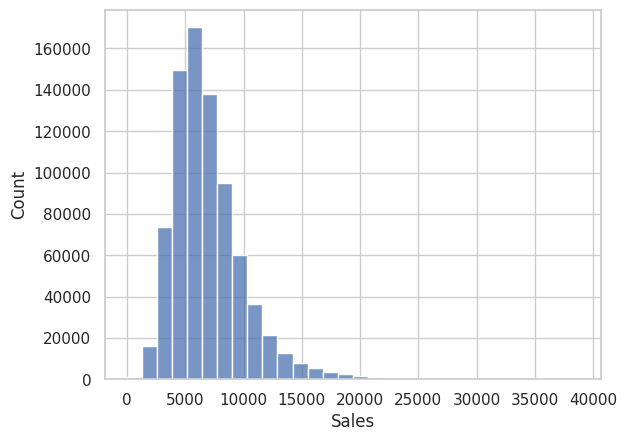

In [56]:
sns.histplot(data=df_train, x="Sales", bins=30)

**Hypothesis:**

**1.** Stores with extended assortment should sell more. **FALSE**

<Axes: xlabel='Assortment', ylabel='Sales'>

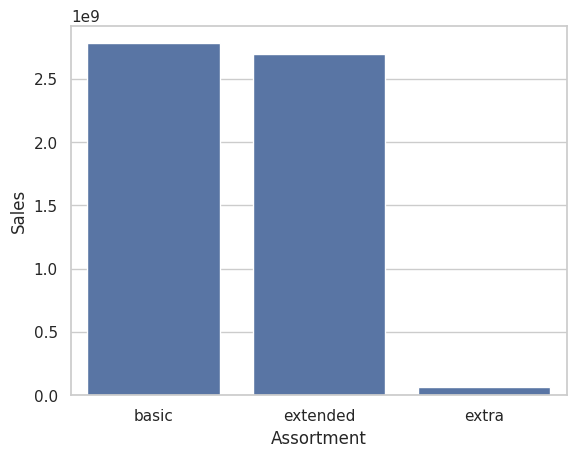

In [57]:
sns.barplot(df_train.groupby("Assortment")["Sales"].sum())

**2.** Stores with closer competitors should sell less. **FALSE**

In [58]:
hyp2 = df_train[["CompetitionDistance", "Assortment", "Sales"]]\
    .groupby(["CompetitionDistance", "Assortment"])["Sales"].sum().reset_index()
hyp2

,CompetitionDistance,Assortment,Sales
0,20.0,extended,4326285
1,30.0,basic,12647304
2,30.0,extended,3938476
3,40.0,basic,27817434
4,50.0,basic,19903989
...,...,...,...
790,46590.0,extended,3355231
791,48330.0,basic,3564184
792,58260.0,extended,5378112
793,75860.0,basic,8090346


<Axes: xlabel='CompetitionDistance', ylabel='Sales'>

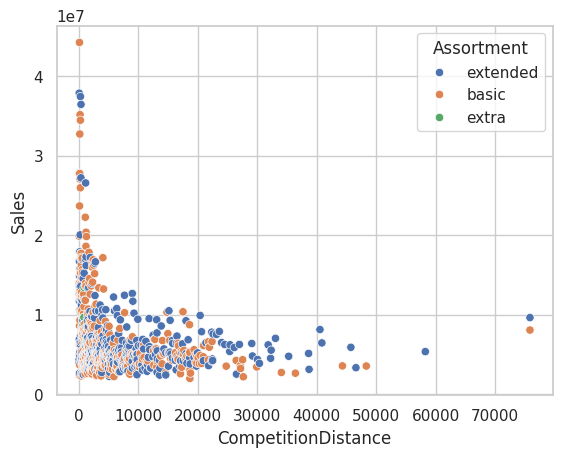

In [59]:
sns.scatterplot(data=hyp2, x="CompetitionDistance", y="Sales", hue="Assortment")

**3.** Stores with long-standing competitors should sell more. **Slightly TRUE**

In [60]:
max_year_sales = df_train.groupby(["Store"])["Date"].max().dt.year.reset_index()
max_year_sales.rename(columns={"Date": "CurrentYear"}, inplace=True)

In [61]:
hyp3 = df_train[["Store", "CompetitionOpenSinceYear", "Sales"]]\
    .groupby(["Store", "CompetitionOpenSinceYear"])["Sales"].sum().reset_index()

In [62]:
hyp3 = pd.merge(hyp3, max_year_sales, on="Store", how="left")
hyp3["CompetitionOpenedWeeks"] = (hyp3["CurrentYear"] - hyp3["CompetitionOpenSinceYear"]) * 52

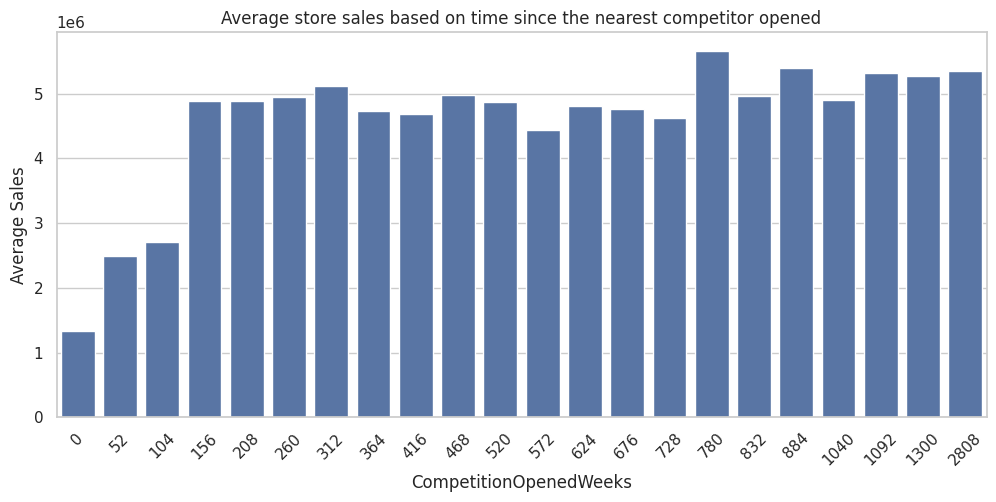

In [63]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(hyp3.groupby("CompetitionOpenedWeeks")["Sales"].mean(), ax=ax)
#sns.barplot(data=hyp3, x="CompetitionOpenedWeeks", y="Sales", ax=ax, errorbar="sd")
plt.title("Average store sales based on time since the nearest competitor opened")
plt.ylabel("Average Sales")
plt.xticks(rotation=45);

**4.** Stores opened in Christmas holiday shoul sell more. **FALSE**

In [64]:
df_train.groupby("StateHoliday")["Sales"].sum()

StateHoliday
easter       1433744
none      5532412299
public       5890305
xmas          691806
Name: Sales, dtype: int64

In [65]:
hyp4a = df_train.query("StateHoliday != 'none'").groupby("StateHoliday")["Sales"].sum().reset_index().sort_values(by="Sales")

In [66]:
hyp4b = df_train[["Date", "StateHoliday", "Sales"]].groupby([df_train["Date"].dt.year, "StateHoliday"])["Sales"].sum().reset_index()
hyp4b = hyp4b[hyp4b["StateHoliday"] != "none"]

<Axes: xlabel='Date', ylabel='Sales'>

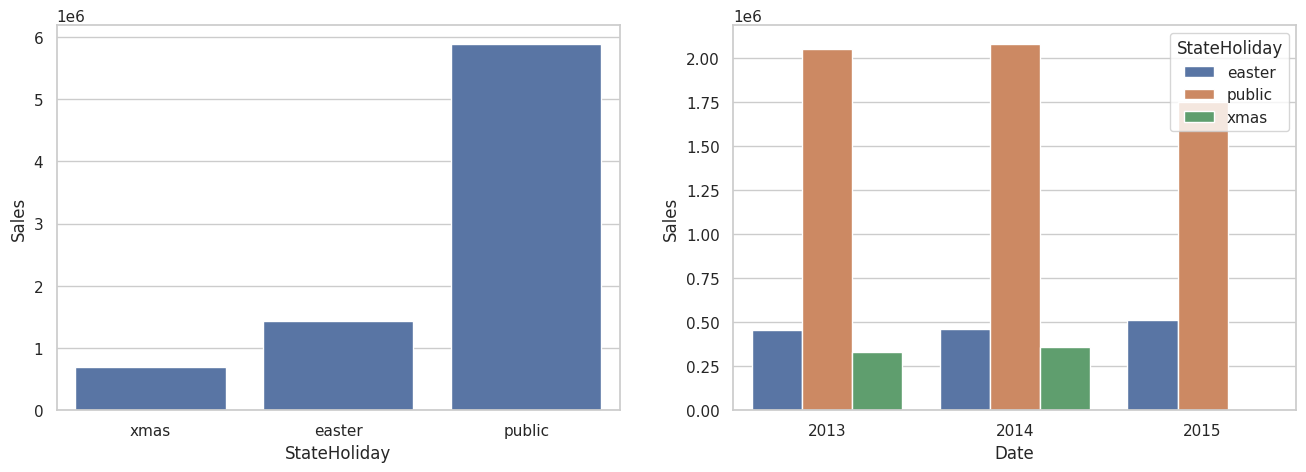

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
sns.barplot(data=hyp4a, x="StateHoliday", y="Sales", ax=ax[0])
sns.barplot(data=hyp4b, x="Date", y="Sales", hue="StateHoliday", ax=ax[1])

**5.** Stores should sell more over the years. **IN AVERAGE IS SLIGHTLY TRUE**; **IN ABSOLUTE VALUES IS FALSE**

Text(0, 0.5, 'Total Sales')

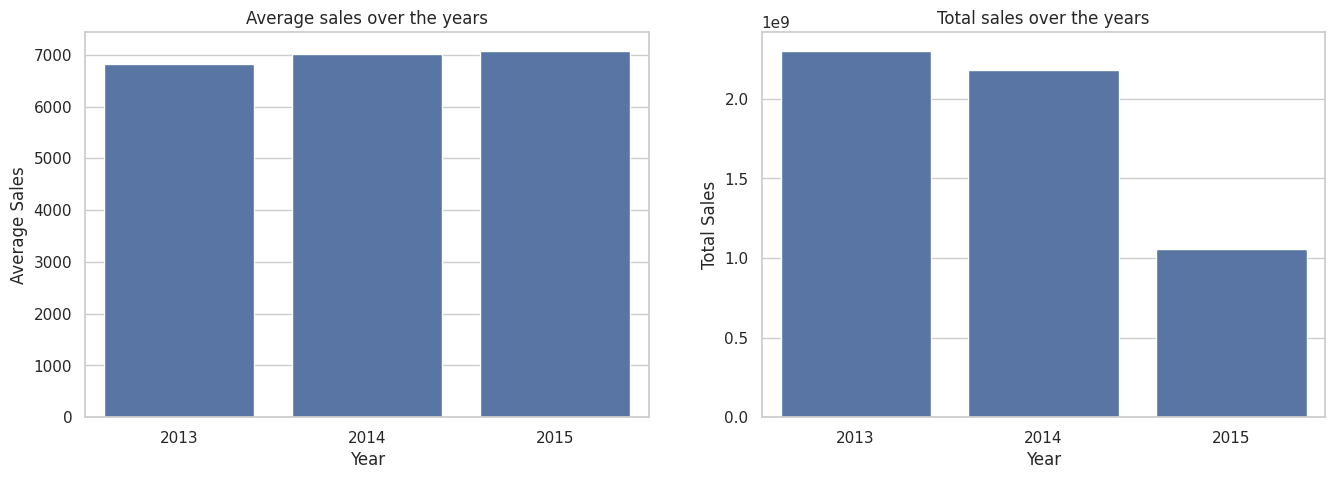

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16 ,5))
sns.barplot(df_train.groupby(df_train["Date"].dt.year)["Sales"].mean(), ax=ax[0])
sns.barplot(df_train.groupby(df_train["Date"].dt.year)["Sales"].sum(), ax=ax[1])
ax[0].set_title("Average sales over the years")
ax[1].set_title("Total sales over the years")
ax[0].set_xlabel("Year")
ax[1].set_xlabel("Year")
ax[0].set_ylabel("Average Sales")
ax[1].set_ylabel("Total Sales")

**6.** Stores should sell more in the second half of the year. **FALSE**

In [69]:
hyp6a = df_train.groupby([df_train["Date"].dt.year, df_train["Date"].dt.month])[["Sales"]].sum()
hyp6a.index.names = ["Year", "Month"]
hyp6a = hyp6a.reset_index()

/home/ezequielpf/.pyenv/versions/venv_rossmann/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


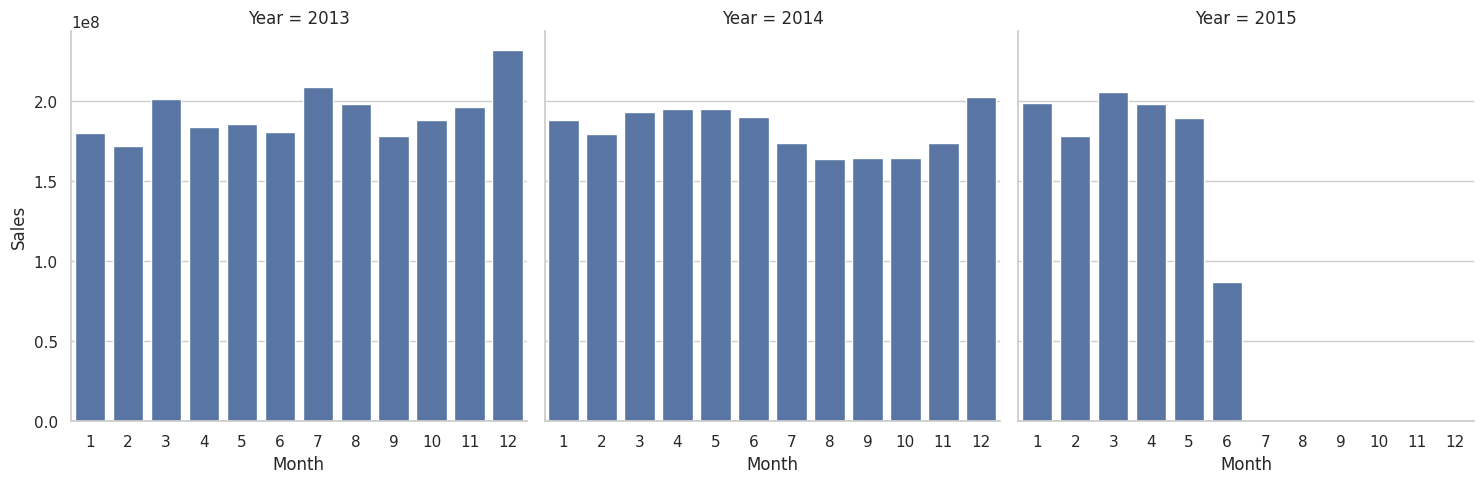

In [70]:
fig = sns.FacetGrid(data=hyp6a, col="Year", sharey=True, height=5)
fig.map(sns.barplot, "Month", "Sales")

/home/ezequielpf/.pyenv/versions/venv_rossmann/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


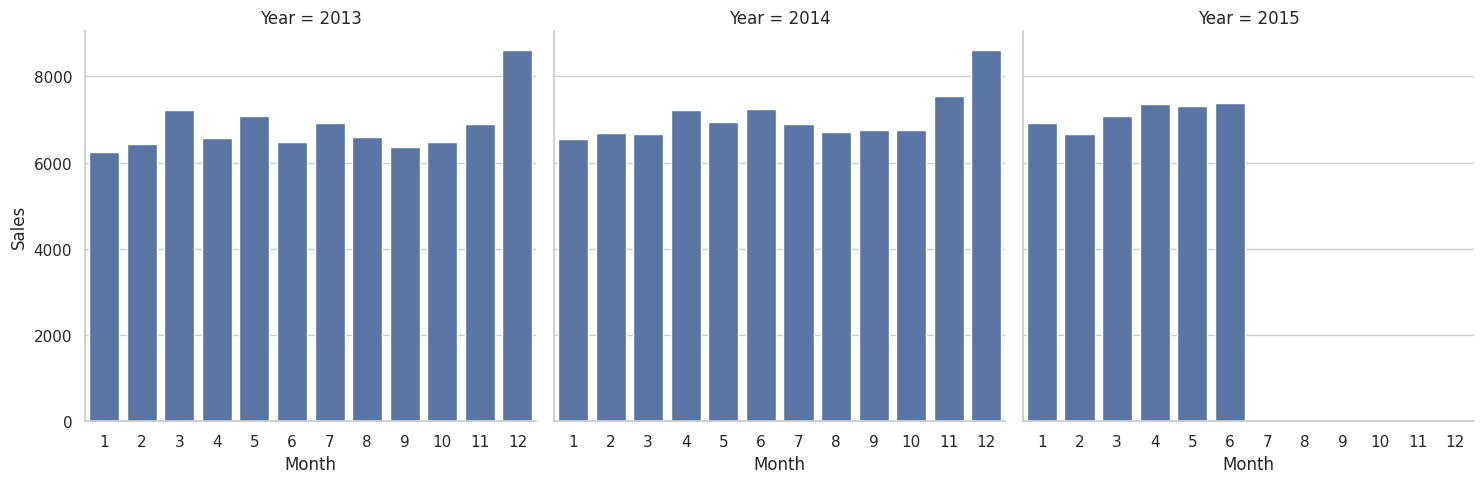

In [71]:
hyp6b = df_train.groupby([df_train["Date"].dt.year, df_train["Date"].dt.month])[["Sales"]].mean()
hyp6b.index.names = ["Year", "Month"]
hyp6b = hyp6b.reset_index()
fig = sns.FacetGrid(data=hyp6b, col="Year", sharey=True, height=5)
fig.map(sns.barplot, "Month", "Sales")

In [72]:
hyp6a["Sem"] = hyp6a["Month"].apply(lambda x: 1 if x <= 6 else 2)

<Axes: xlabel='Sem', ylabel='Sales'>

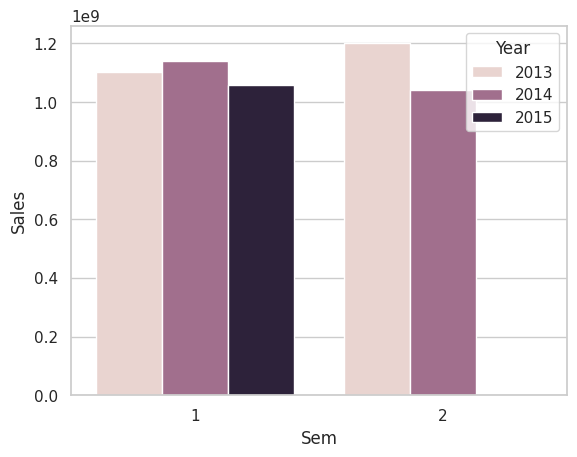

In [75]:
sns.barplot(data=hyp6a.groupby(["Year", "Sem"])["Sales"].sum().reset_index(), x="Sem", y="Sales", hue="Year")

**7.** Stores should sell less on weekends. **IN AVERAGE IS FALSE**

/tmp/ipykernel_54234/3250334350.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
/tmp/ipykernel_54234/3250334350.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]);


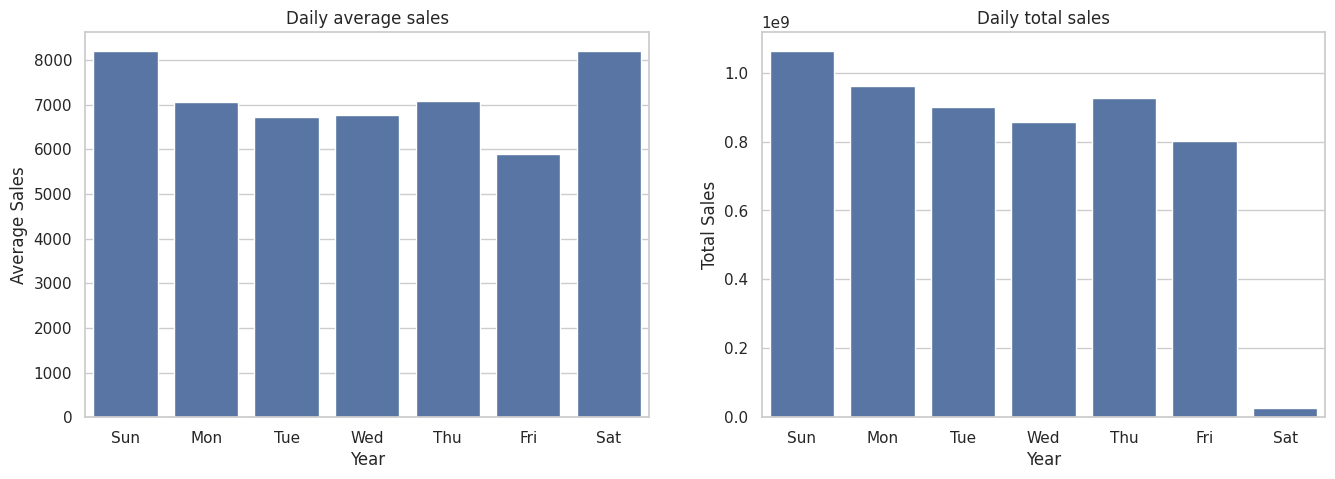

In [103]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
sns.barplot(data=df_train.groupby("DayOfWeek")["Sales"].mean().reset_index(), x="DayOfWeek", y="Sales", ax=ax[0])
sns.barplot(data=df_train.groupby("DayOfWeek")["Sales"].sum().reset_index(), x="DayOfWeek", y="Sales", ax=ax[1])
ax[0].set_title("Daily average sales")
ax[1].set_title("Daily total sales")
ax[0].set_xlabel("Year")
ax[1].set_xlabel("Year")
ax[0].set_ylabel("Average Sales")
ax[1].set_ylabel("Total Sales")
#ax[0].set_xticks([1,2,3,4,5,6,7])
ax[0].set_xticklabels(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
#ax[1].set_xticks([1,2,3,4,5,6,7])
ax[1].set_xticklabels(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]);

**8.** Stores should sell less during school holidays. **TRUE FOR TOTAL SALES**

Text(0, 0.5, 'Total Sales')

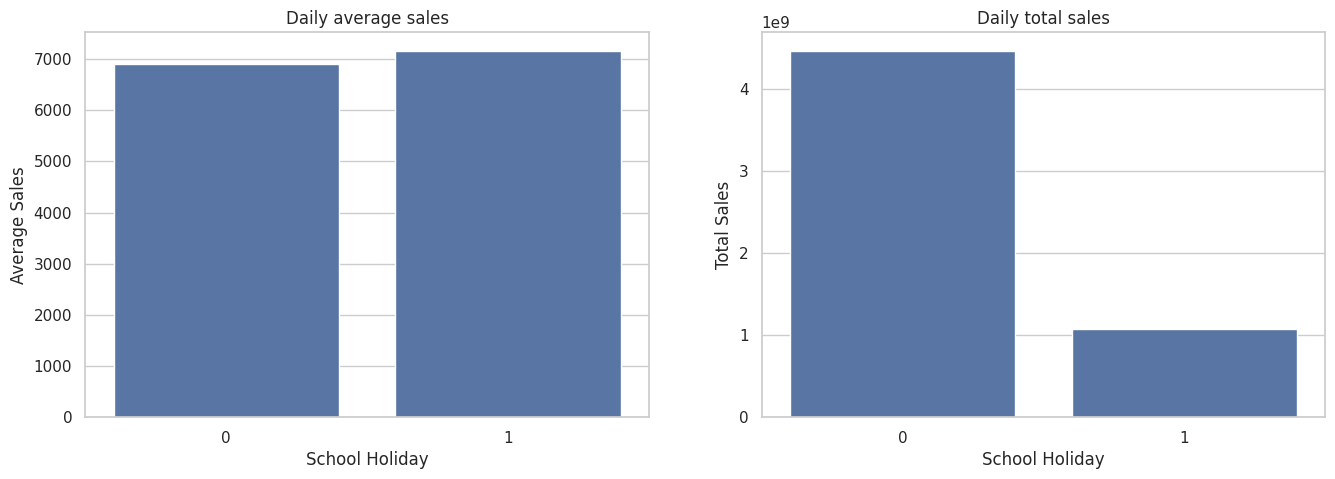

In [111]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
sns.barplot(data=df_train.groupby("SchoolHoliday")["Sales"].mean().reset_index(), x="SchoolHoliday", y="Sales", ax=ax[0])
sns.barplot(data=df_train.groupby("SchoolHoliday")["Sales"].sum().reset_index(), x="SchoolHoliday", y="Sales", ax=ax[1])
ax[0].set_title("Daily average sales")
ax[1].set_title("Daily total sales")
ax[0].set_xlabel("School Holiday")
ax[1].set_xlabel("School Holiday")
ax[0].set_ylabel("Average Sales")
ax[1].set_ylabel("Total Sales")